In [1]:
import torch
from torch import nn

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the data

In [53]:
PATH_DATA = r"./sensitive_data"

data_raw = dict()
for bearbeitung in [3, 4, 10]:
    data_raw[bearbeitung] = []
    dirname = f"{PATH_DATA}/Bearbeitung_{bearbeitung:02d}"
    for j, filename in enumerate(sorted(os.listdir(dirname), key=lambda s: s.split("_")[-1]), start=1):
        df = pd.read_csv(f"{dirname}/{filename}")
        data_raw[bearbeitung].append((
            pd.to_datetime(df["TimeStamp"]).to_numpy(),
            df["FastNc_axis_SP1_AxTorqueAct"].to_numpy()
        ))

In [56]:
def feature(x):
    return np.sum(np.abs(x))
    # return np.max(moving_average(np.abs(x), 100))

[ 18  38  62  85  99 121 146 169]
[20 24 23 14 22 25 23]


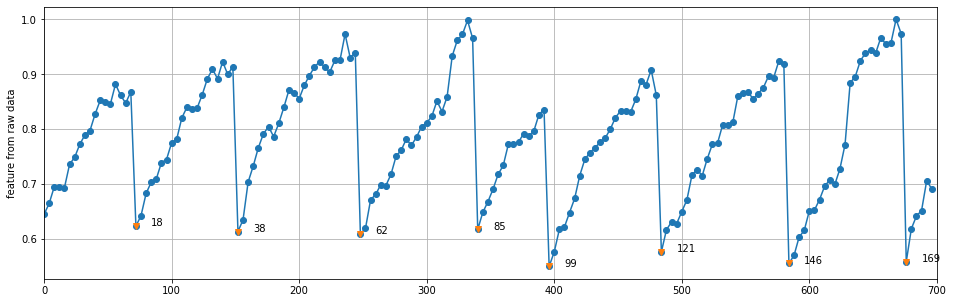

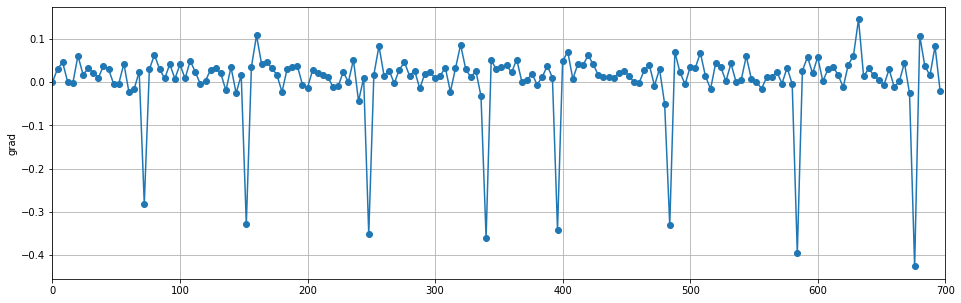

In [57]:
plt.figure(figsize=(16, 5))

subsample = 4

x = np.arange(len(data_raw[bearbeitung]))[::subsample]

bearbeitung = 10
f = np.asarray([feature(x) for _, x in data_raw[bearbeitung][::subsample]])
# f -= np.min(f) + 1e-10
f /= np.max(f)

grad = np.zeros_like(f)
grad[1:] = f[1:] / f[:-1] - 1

plt.plot(x,f, "o-")

# j = 120
# plt.plot([j], [f[j]], "o")
# n = 30
# q = np.polyfit(np.arange(j-n, j+1), f[j-n:j+1], 1)
# x_eval = [subsample*(j-n+1), j+30]
# plt.plot(x_eval, np.polyval(q, x_eval), color="C1", linestyle="--")

j = np.where(grad < -0.2)[0]
print(j)
print(j[1:] - j[:-1])
plt.plot(j*subsample, f[j], "v")
for k in j:
    plt.text(subsample*(k + 3), f[k], f"{k}")

plt.xlim(0, 700)
plt.ylabel("feature from raw data")
plt.grid(True)
plt.show()

# Figure 2
plt.figure(figsize=(16, 5))
plt.plot(x,grad, "o-")
plt.grid(True)
plt.ylabel("grad")
plt.xlim(0, 700)
plt.show()

# 1b. Setup training and test data (inputs & labels)

In [36]:
def linreg(y):
    X = np.linspace(0,1,len(y))
#     k = np.sum(np.multiply(X-np.mean(X),y-np.mean(y))) / np.sum((X-np.mean(X))**2)
#     d = np.mean(y) - k * np.mean(X)
    
    k,d = np.polyfit(X,y,1)
    
    return [k]

### Training data from machine data

In [244]:
# training data from machine data
data = []
for j_, _j in zip(j[:-1], j[1:]):
    data += [[f[i+k] for k in range(N)] for i in range(j_,_j - 3)]

print(f"training input data (len: {len(data)})")


training input data (len: 130)


### Synthetic training data

In [37]:
# synthetic training data
l = 40000  # data set length
N = 4     # number of inputs

X = np.array([np.random.uniform(0,1,N) for _ in range(l)])
Y = np.array([linreg(x) for x in X])
print(X.shape)

(40000, 4)


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

(36000, 4) (4000, 4)


In [39]:
X_test[:2]

tensor([[0.6341, 0.0437, 0.7958, 0.8043],
        [0.9312, 0.1553, 0.1424, 0.4420]])

# 2. Define a model that might work in concrete

In [47]:
class FCFill(torch.nn.Module):

    def __init__(self, input_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, 3)
        self.relu1 = nn.ReLU6()

        self.fc2 = nn.Linear(3, 3)
        self.relu2 = nn.ReLU6()
        
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x


In [48]:
def train():
    for iter in range(n_iters):
        # Get a random batch of training data
        idx = torch.randperm(X_train.size()[0])
        X_batch = X_train[idx][:batch_size]
        y_batch = y_train[idx][:batch_size]

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()


        if iter % 5000 == 0:
            # Print epoch number, loss
            print(f'Iterations: {iter:5} | Loss: {loss.item():.9f}')
            if loss.item() < 1e-9:
                print("Training done")
                break

In [49]:
# Initialize our model
model = FCFill(X.shape[1])

# Define our loss function
criterion = nn.MSELoss()

# Define our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Define the number of iterations
n_iters = 50001

# Define the batch size
batch_size = 16

# 3. Train the model

In [50]:
train()

Iterations:     0 | Loss: 0.189050883
Iterations:  5000 | Loss: 0.000043498
Iterations: 10000 | Loss: 0.000024858
Iterations: 15000 | Loss: 0.000000055
Iterations: 20000 | Loss: 0.000021698
Iterations: 25000 | Loss: 0.000000160
Iterations: 30000 | Loss: 0.000000033
Iterations: 35000 | Loss: 0.000000300
Iterations: 40000 | Loss: 0.000000120
Iterations: 45000 | Loss: 0.000000000
Training done


In [45]:
y_pred = model(X_test)
print(f"mean error: {(y_pred - y_test).abs().mean()}")

mean error: 4.523775351117365e-05


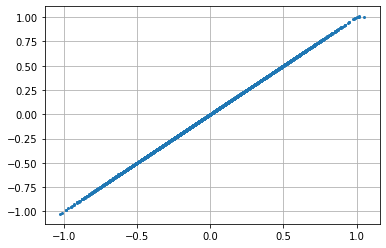

In [46]:
y_test_numpy = y_test.numpy()
plt.plot(y_test_numpy, y_pred.cpu().detach().numpy(), "o", markersize=2)
plt.grid()

plt.show()

Analytic:
k = -0.1810
d = 0.5363

NN:
a = -0.1945
b = 0.5406


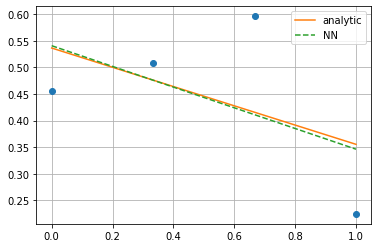

In [16]:
# Example inference
np_inp = np.random.uniform(0,1,N)
inp = torch.tensor(np_inp).float()
plt.plot(np.linspace(0,1,N),np_inp,"o")

# analytic
k,d = linreg(np_inp)
print(f"Analytic:\nk = {k:.4f}\nd = {d:.4f}")

plt.plot([0,1],[d, k+d], label="analytic")

# NN
pred = model(inp)
a = pred[0].item()
b = pred[1].item()
print(f"\nNN:\na = {a:.4f}\nb = {b:.4f}")
plt.plot([0,1],[b, a+b], "--", label = "NN")

plt.legend()
plt.grid()
plt.show()

In [589]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0416, -0.1345, -0.8230, -1.0544],
        [-1.6048, -0.8384, -0.0416,  0.7422],
        [-0.6254,  0.2719,  0.3652,  1.1598]], requires_grad=True)
Parameter containing:
tensor([ 0.7107,  0.7326, -0.3074], requires_grad=True)
Parameter containing:
tensor([[ 0.6431, -1.7507, -0.4999],
        [-1.6657,  1.4153,  1.0496],
        [-1.1017, -2.2191,  0.6810]], requires_grad=True)
Parameter containing:
tensor([ 0.0607, -0.7510,  0.6273], requires_grad=True)
Parameter containing:
tensor([[-1.9350,  2.8580, -0.5999],
        [ 0.9063, -0.5812,  2.6842]], requires_grad=True)
Parameter containing:
tensor([-0.4274, -0.5509], requires_grad=True)


In [590]:
from concrete.torch.compile import compile_torch_model

try:
    print("Compiling the model to FHE.")
    quantized_compiled_module = compile_torch_model(
        model,
        X_train,
        #X_test[:100],
        n_bits=3,
    )
    print("The network is trained and FHE friendly.")
except Exception as e:
    if str(e).startswith("max_bit_width of some nodes is too high"):
        print(f'The network is not fully FHE friendly, retrain.')
    else:
        raise e

Compiling the model to FHE.
The network is trained and FHE friendly.


Analytic:
k = 0.7560
d = 0.2537

NN:
a = 0.7349
b = 0.2374

Quantized:
[[39 24]]
[[ 0.29987758 -0.26239288]]


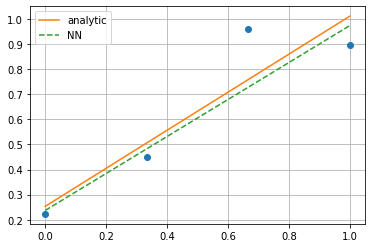

In [687]:
# Example inference
np_inp = np.random.uniform(0,1,N)
inp = torch.tensor(np_inp).float()
plt.plot(np.linspace(0,1,N),np_inp,"o")

# analytic
k,d = linreg(np_inp)
print(f"Analytic:\nk = {k:.4f}\nd = {d:.4f}")

plt.plot([0,1],[d, k+d], label="analytic")

# NN
pred = model(inp)
a = pred[0].item()
b = pred[1].item()
print(f"\nNN:\na = {a:.4f}\nb = {b:.4f}")
plt.plot([0,1],[b, a+b], "--", label = "NN")

# Quantized
q_pred = quantized_compiled_module(np_inp)
print(f"\nQuantized:\n{q_pred}")
he_result = quantized_compiled_module.dequantize_output(
    np.array(q_pred, dtype=np.float32).reshape((1,2))
)
print(he_result)

# # HOMOMORPHIC
# he_pred = quantized_compiled_module.forward_fhe.run(np.array([np_inp]).astype(np.uint8))

# he_result = quantized_compiled_module.dequantize_output(
#     np.array([he_pred], dtype=np.float32).reshape((1,2))
# )

# a = he_result[0][0].item()
# b = he_result[0][1].item()
# print(f"\nHE:\na = {a:.4f}\nb = {b:.4f}")
# print(he_pred)
# plt.plot([0,1],[b, a+b], "--", label = "HE")

plt.legend()
plt.grid()
plt.show()

In [619]:
for name,layer in quantized_compiled_module.quant_layers_dict.items():
    print(layer)

# 4. evaluate

In [136]:
y_pred = model(X_test)

In [137]:
# We now have a module in full numpy.
# Convert data to a numpy array.
X_train_numpy = X_train.numpy()
X_test_numpy = X_test.numpy()
y_train_numpy = y_train.numpy()
y_test_numpy = y_test.numpy()

quant_model_predictions = quantized_compiled_module(X_test_numpy)

In [344]:
z = quantized_compiled_module([0,0,0,0])
print(z)
quantized_compiled_module.dequantize_output(z)

[[38 31]]


array([[0.37255512, 0.1552313 ]])

In [138]:
from tqdm import tqdm
homomorphic_quant_predictions = []
for x_q in tqdm(X_test_numpy):
    homomorphic_quant_predictions.append(
        quantized_compiled_module.forward_fhe.run(np.array([x_q]).astype(np.uint8))
    )
    
homomorphic_predictions = quantized_compiled_module.dequantize_output(
    np.array(homomorphic_quant_predictions, dtype=np.float32).reshape(quant_model_predictions.shape)
)

  0%|          | 28/10000 [03:48<22:38:27,  8.17s/it]


KeyboardInterrupt: 

In [ ]:
print(f'Test Accuracy: {100*(y_pred.argmax(1) == y_test).float().mean():.2f}%')
print(f'Test Accuracy Quantized Inference: {100*(quant_model_predictions.argmax(1) == y_test_numpy).mean():.2f}%')
print(f'Test Accuracy Homomorphic Inference: {100*(homomorphic_predictions.argmax(1) == y_test_numpy).mean():.2f}%')